# Using Autoencoders for Missing Data Imputation
Ethan Harvey

In [1]:
import numpy as np
import pandas as pd

import keras
from keras.datasets import mnist
from keras import layers
from xgboost import XGBClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### MNIST

In [2]:
# load MNIST data
(X_train, y_train), (X_validation, y_validation) = mnist.load_data()
X_train = np.reshape(X_train, (60000,784))
X_validation = np.reshape(X_validation, (10000,784))
X_train = X_train.astype('float32')/255
X_validation = X_validation.astype('float32')/255

In [3]:
def add_missing_values(X, percent_missing=0.75, missing_columns=0.5, missing_percent=0.15):
    # percent is the percent of datapoints with missing values
    # missing is the percent of datapoints missing from datapoints with missing values
    num_samples, num_features = X.shape
    missing_rows = np.random.choice([True, False], size=num_samples, p=[percent_missing, 1-percent_missing])
    num_missing_columns = int(missing_columns*num_features)
    missing_values = np.random.choice([True, False], size=(sum(missing_rows),num_missing_columns), p=[missing_percent, 1-missing_percent])
    missing_values = np.hstack((np.zeros((sum(missing_rows),num_features-num_missing_columns)),missing_values))
    X_copy = X[missing_rows==True]
    X_copy[missing_values==True] = np.nan
    X[missing_rows==True] = X_copy
    return X

In [4]:
X_train = add_missing_values(X_train.copy())
X_validation = add_missing_values(X_validation.copy())

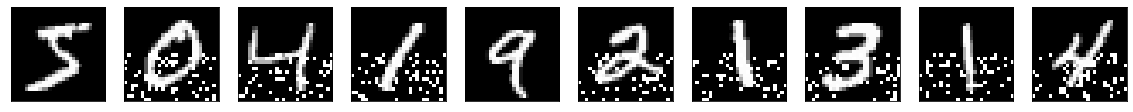

In [5]:
# display dataset with missing values
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
X_train_complete = X_train[~np.isnan(X_train).any(axis=1)]
X_train_missing = X_train[np.isnan(X_train).any(axis=1)]
X_validation_complete = X_validation[~np.isnan(X_validation).any(axis=1)]
X_validation_missing = X_validation[np.isnan(X_validation).any(axis=1)]

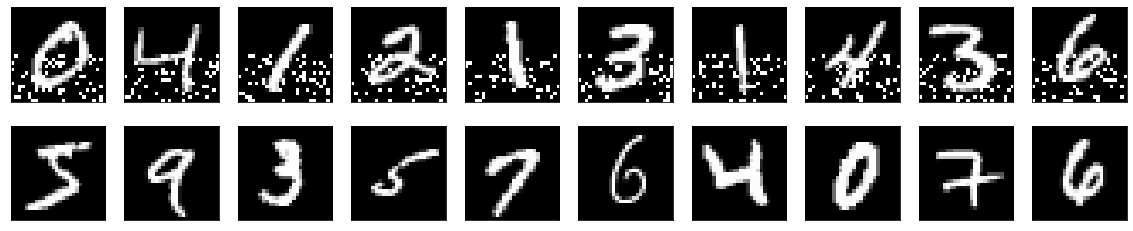

In [7]:
# display trianing set split into a set with missing values and a set without
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train_missing[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_train_complete[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
X_train_complete_missing = add_missing_values(X_train_complete.copy(), 1)

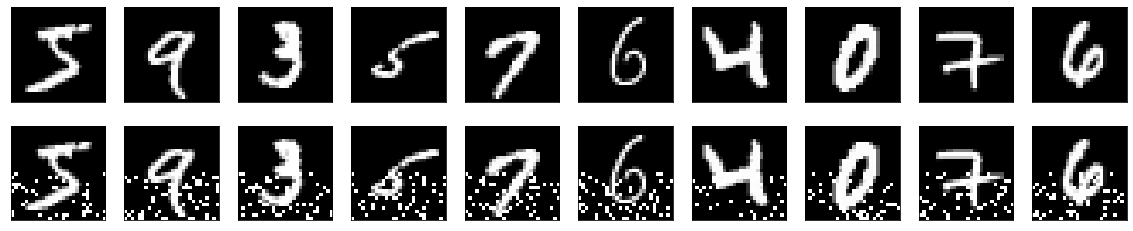

In [9]:
# display training set without missing values and training set with artifical missing values
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train_complete[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_train_complete_missing[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
# change np.nans to 1
num = 1
X_train_complete[np.isnan(X_train_complete)] = num
X_train_missing[np.isnan(X_train_missing)] = num
X_validation_complete[np.isnan(X_validation_complete)] = num
X_validation_missing[np.isnan(X_validation_missing)] = num
X_train_complete_missing[np.isnan(X_train_complete_missing)] = num

In [11]:
# spliting training data into a train and test set
train_idx = np.random.choice([True, False], size=X_train_complete.shape[0], p=[0.7, 0.3])
# train autoencoder
num_features = 784
encoding_dim = 500
input_img = keras.Input(shape=(num_features,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(num_features, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train_complete_missing[train_idx], X_train_complete[train_idx], epochs=10,\
                validation_data=(X_train_complete_missing[~train_idx], X_train_complete[~train_idx]))

2022-06-13 08:55:06.252384: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 08:55:06.252921: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


Train on 10470 samples, validate on 4499 samples
Epoch 1/10
10470/10470 [==============================] - 7s 675us/step - loss: 0.1614 - val_loss: 0.1080
Epoch 2/10
10470/10470 [==============================] - 7s 634us/step - loss: 0.0971 - val_loss: 0.0923
Epoch 3/10
10470/10470 [==============================] - 7s 632us/step - loss: 0.0869 - val_loss: 0.0867
Epoch 4/10
10470/10470 [==============================] - 7s 654us/step - loss: 0.0821 - val_loss: 0.0843
Epoch 5/10
10470/10470 [==============================] - 9s 826us/step - loss: 0.0792 - val_loss: 0.0819
Epoch 6/10
10470/10470 [==============================] - 6s 613us/step - loss: 0.0773 - val_loss: 0.0809
Epoch 7/10
10470/10470 [==============================] - 7s 622us/step - loss: 0.0760 - val_loss: 0.0802
Epoch 8/10
10470/10470 [==============================] - 7s 645us/step - loss: 0.0749 - val_loss: 0.0796
Epoch 9/10
10470/10470 [==============================] - 7s 679us/step - loss: 0.0742 - val_loss: 0.07

In [12]:
encoded_imgs = encoder.predict(X_train_missing)
decoded_imgs = decoder.predict(encoded_imgs)

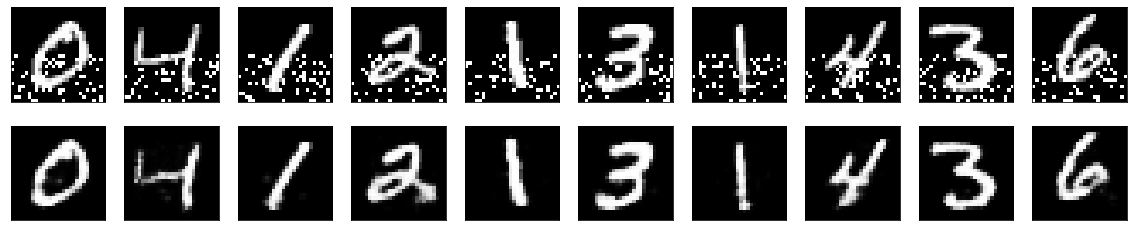

In [13]:
# display training set with missing values and predicted values from autoencoder
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train_missing[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
# train a model using datapoints without missing values and predict all datapoints
model = XGBClassifier()
model.fit(X_train[~np.isnan(X_train).any(axis=1)], y_train[~np.isnan(X_train).any(axis=1)])
model.score(X_validation, y_validation)

[08:56:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9568

In [15]:
# train a model using datapoints without missing values and predict datapoints without missing values
model = XGBClassifier()
model.fit(X_train[~np.isnan(X_train).any(axis=1)], y_train[~np.isnan(X_train).any(axis=1)])
model.score(X_validation[~np.isnan(X_validation).any(axis=1)], y_validation[~np.isnan(X_validation).any(axis=1)])

[08:57:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9605633802816902

In [16]:
# train an autoencoder to fill missing values in training data
# train a model using all training data and to predict all validation data
train_idx = np.random.choice([True, False], size=X_train_complete.shape[0], p=[0.7, 0.3])
# train autoencoder
num_features = 784
encoding_dim = 500
input_img = keras.Input(shape=(num_features,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(num_features, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train_complete_missing[train_idx], X_train_complete[train_idx], epochs=10, verbose=0,\
                validation_data=(X_train_complete_missing[~train_idx], X_train_complete[~train_idx]))
# fill missing values in training data
encoded_imgs = encoder.predict(X_train_missing)
decoded_imgs = decoder.predict(encoded_imgs)
X_train_filled = X_train.copy()
X_train_filled[np.isnan(X_train).any(axis=1)] = decoded_imgs
# fill missing values in testing data
encoded_imgs = encoder.predict(X_validation_missing)
decoded_imgs = decoder.predict(encoded_imgs)
X_validation_filled = X_validation.copy()
X_validation_filled[np.isnan(X_validation).any(axis=1)] = decoded_imgs

In [17]:
# train a model using datapoints without missing values and predict datapoints without missing values
model = XGBClassifier()
model.fit(X_train_filled, y_train)
model.score(X_validation_filled, y_validation)

[08:59:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9715

In [18]:
# train a model using datapoints without missing values and predict datapoints without missing values
model = XGBClassifier()
model.fit(X_train_filled, y_train)
model.score(X_validation[~np.isnan(X_validation).any(axis=1)], y_validation[~np.isnan(X_validation).any(axis=1)])

[09:08:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9722334004024145